In [1]:
from utils import plot_history, plot_result, calc_mean_image_metrics, predict_all
from losses import ssim_l2

In [2]:
import numpy as np

import os
import gc

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import callbacks
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
images_clear_tt = np.load('images_clear_tt.npy')
images_noised_tt = np.load('images_noised_tt.npy')
images_clear_val = np.load('images_clear_val.npy')
images_noised_val = np.load('images_noised_val.npy')

In [5]:
images_noised_train, images_noised_test, images_clear_train, images_clear_test = train_test_split(images_noised_tt,
                                                                                                 images_clear_tt,
                                                                                                 test_size=0.2,
                                                                                                 random_state=42)

In [9]:
#del images_clear_tt
#del images_noised_tt
#del images_clear_val
#del images_noised_val

In [37]:
def ae():

    img_shape=(256, 256, 3)

    input = Input(img_shape)
    encode = Conv2D(512, kernel_size=(3,3), padding='same')(input)
    encode = BatchNormalization()(encode)
    encode = Activation('gelu')(encode)
    encode = AveragePooling2D(pool_size=(2,2))(encode)
    encode = Conv2D(256, kernel_size=(3,3), padding='same')(encode)
    encode = BatchNormalization()(encode)
    encode = Activation('gelu')(encode)
    encode = AveragePooling2D(pool_size=(2,2))(encode)

    decode = Conv2DTranspose(256, kernel_size=(3,3), strides=2, padding='same')(encode)
    decode = BatchNormalization()(decode)
    decode = Activation('gelu')(decode)
    decode = Conv2DTranspose(512, kernel_size=(3,3), strides=2, padding='same')(decode)
    decode = BatchNormalization()(decode)
    decode = Activation('gelu')(decode)

    out = Conv2DTranspose(3, kernel_size=(3,3), activation='gelu', padding='same')(decode)

    ae = Model(input, out)

    ae.summary() 
    
    return ae

In [58]:
model = ae()
reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss',
                                        factor=0.1,
                                        patience=5)

model.compile(optimizer=Adamax(learning_rate=1e-2), loss=ssim_l2)
gc.collect()

history = model.fit(images_noised_tt[:5000], images_clear_tt[:5000],
                    epochs=15,
                    callbacks=[reduce_lr],
                    validation_split = 0.2,
                    #validation_data=(images_noised_test, images_clear_test),
                    batch_size=1)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_14 (Conv2D)          (None, 256, 256, 256)     7168      
                                                                 
 batch_normalization_27 (Bat  (None, 256, 256, 256)    1024      
 chNormalization)                                                
                                                                 
 activation_26 (Activation)  (None, 256, 256, 256)     0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 128, 128, 256)    0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 128, 128, 256)     5900

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:GPU:0 to /job:localhost/replica:0/task:0/device:CPU:0 in order to run TensorDataset: Dst tensor is not initialized. [Op:TensorDataset]

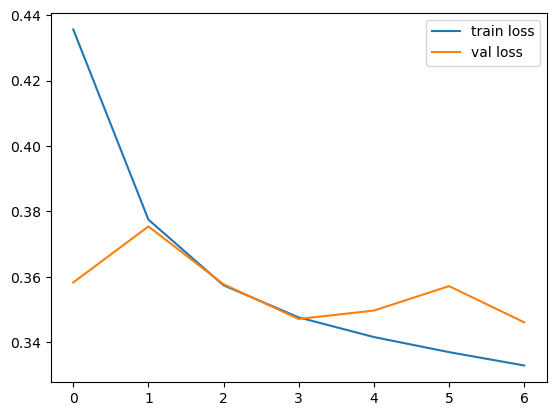

In [44]:
plot_history(history)

In [43]:
y = predict_all(model, images_noised_val)

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 49ms/step


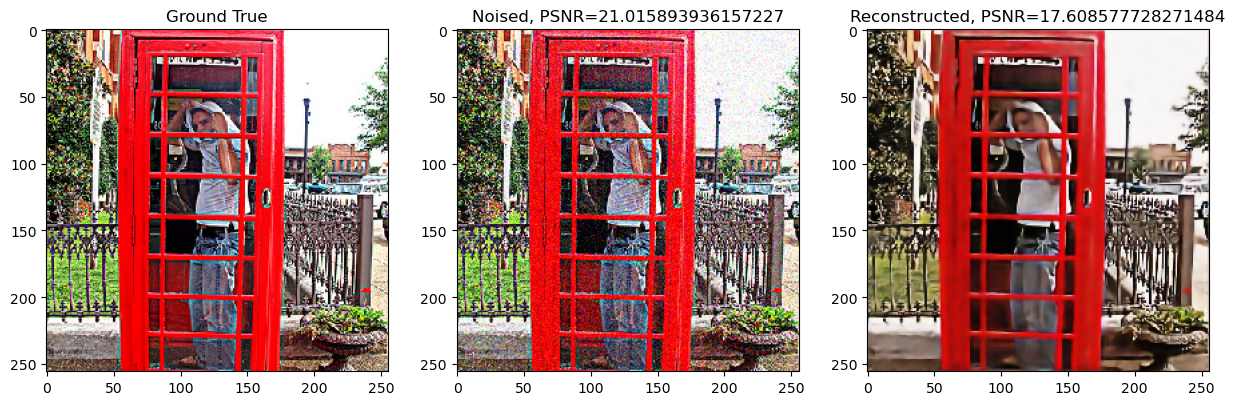

In [57]:
n=334
max_value=1
#psnr, ssim = calc_mean_image_metrics(images_clear_val, y, max_value=max_value)
#print (f'mean PSNR={psnr}')
#print (f'mean SSIM={ssim}')
plot_result(images_clear_val[n],
            images_noised_val[n],
            y[n],
            max_value=max_value
           )

In [51]:
y_t = predict_all(model, images_noised_tt[:100])

1/1 [==============================] - 0s 45ms/step


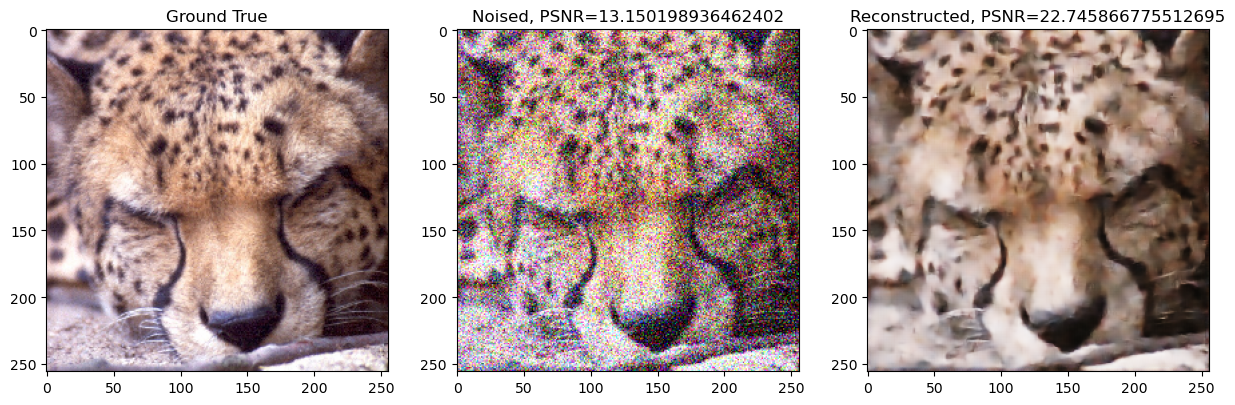

In [53]:
n=5
max_value=1
#psnr, ssim = calc_mean_image_metrics(images_clear_val, y, max_value=max_value)
#print (f'mean PSNR={psnr}')
#print (f'mean SSIM={ssim}')
plot_result(images_clear_tt[n],
            images_noised_tt[n],
            y_t[n],
            max_value=max_value
           )